<a href="https://colab.research.google.com/github/TuringCollegeSubmissions/schivu-DA.3/blob/master/Wine_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download uciml/red-wine-quality-cortez-et-al-2009
! unzip red-wine-quality-cortez-et-al-2009.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 17.0MB/s]
Archive:  red-wine-quality-cortez-et-al-2009.zip
  inflating: winequality-red.csv     


In [7]:
import pandas as pd

In [8]:
import seaborn as sns

In [9]:
import matplotlib.pyplot as plt

In [134]:
df = pd.read_csv("winequality-red.csv")

In [135]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [12]:
quality_count = df.groupby("quality")["quality"].count()

In [13]:
df["quality"].to_csv("quality_count.csv")

In [14]:
import numpy as np

In [15]:
from scipy.stats import pearsonr

In [18]:
import scipy.stats as stats

## Scenario

I'm working for a distribution firm that sells wine to hotels. We want to build a reputation of selling only the best wines. We can hire experts to rate the wines and we're only going to sell wines which get a rating of 7 or better.
<br>
The ratings of the experts are reliable, but there are costs associated with testing a wine this way.
<br>
Given all this, we need a faster, cost-efficient way to select wines which might be of high quality, such that it's woth it to send them to the experts.
<br>
Luckly, we have a database of pre-rated wines, which can be used to get an idea about what characteristics of a wine make for a good candidate.

I will build a model which estimates the quality of a wine. Only the best wines are going to be sent to the experts.
<br>
It's going to be less reliable compared to the ratings of the expert, but much cheaper, so it makes sense to pre-select the wines this way, from a business perspective.

## Acidity anlysis

In [19]:
def plot_pearson(df, x_feature, y_feature, single_tail=False, title=None):
  df = df[df[x_feature].notna() & df[y_feature].notna()]
  r, p = stats.pearsonr(df[x_feature],df[y_feature])
  if single_tail:
    p = p / 2
  plt.figure()
  ax = sns.regplot(x=df[x_feature], y=df[y_feature],
              scatter_kws={'s':2},
              line_kws={'label':"r={0:.2f}\np={1:.2f}".format(r,p)}
              )
  ax.legend();
  ax.set(title=title);

In the following graphs I will present the relation between **pH** and other relevant features.
<br>
I expect **pH** to be anti-correlated with **fixed acidity**, **volatile acidity** and **citric acid**, since lower pH means greater acidity.

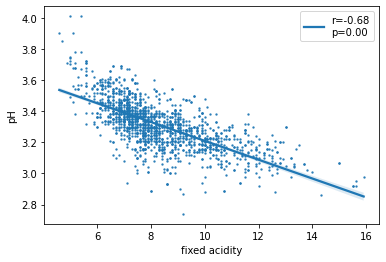

In [20]:
plot_pearson(df, "fixed acidity", "pH")

As expected, **fixed acidity** is anti-correlated with **pH**.

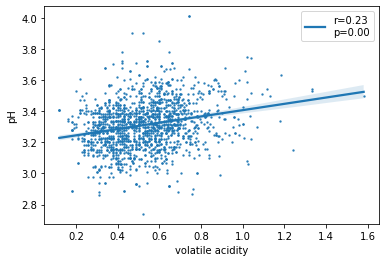

In [21]:
plot_pearson(df, "volatile acidity", "pH")

Counter to my expectations, **volatile acidity** is positively correlated with **pH**. Since volatile acidity in wine is the consequence of acetic acid (vinegar), which is a weak acid, it probably doesn't influence pH directly too much and it's eclipsed by the acidity of other acids.
<br>
Also, high volatile acidity is considered a fault in wine.

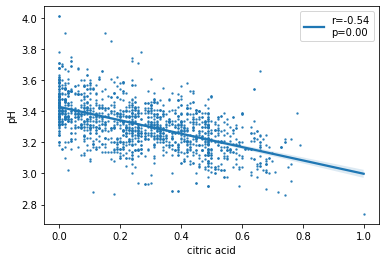

In [22]:
plot_pearson(df, "citric acid", "pH")

As expected, **citric acid** is anti-correlated with **pH**.

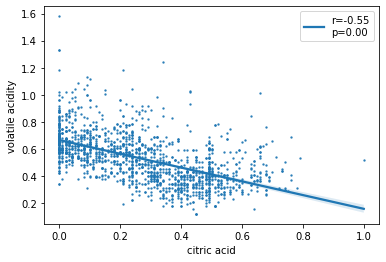

In [23]:
plot_pearson(df, "citric acid", "volatile acidity")

The anti-corrlation between **citric acid** and **volatile acidity** could explain the suprising correlation between **volatile acidity** and **pH**.

## Correlation Matrix

In the following matrix I highlighted with red correlations (or anti-correlations) of magnitude greater than **0.3**.

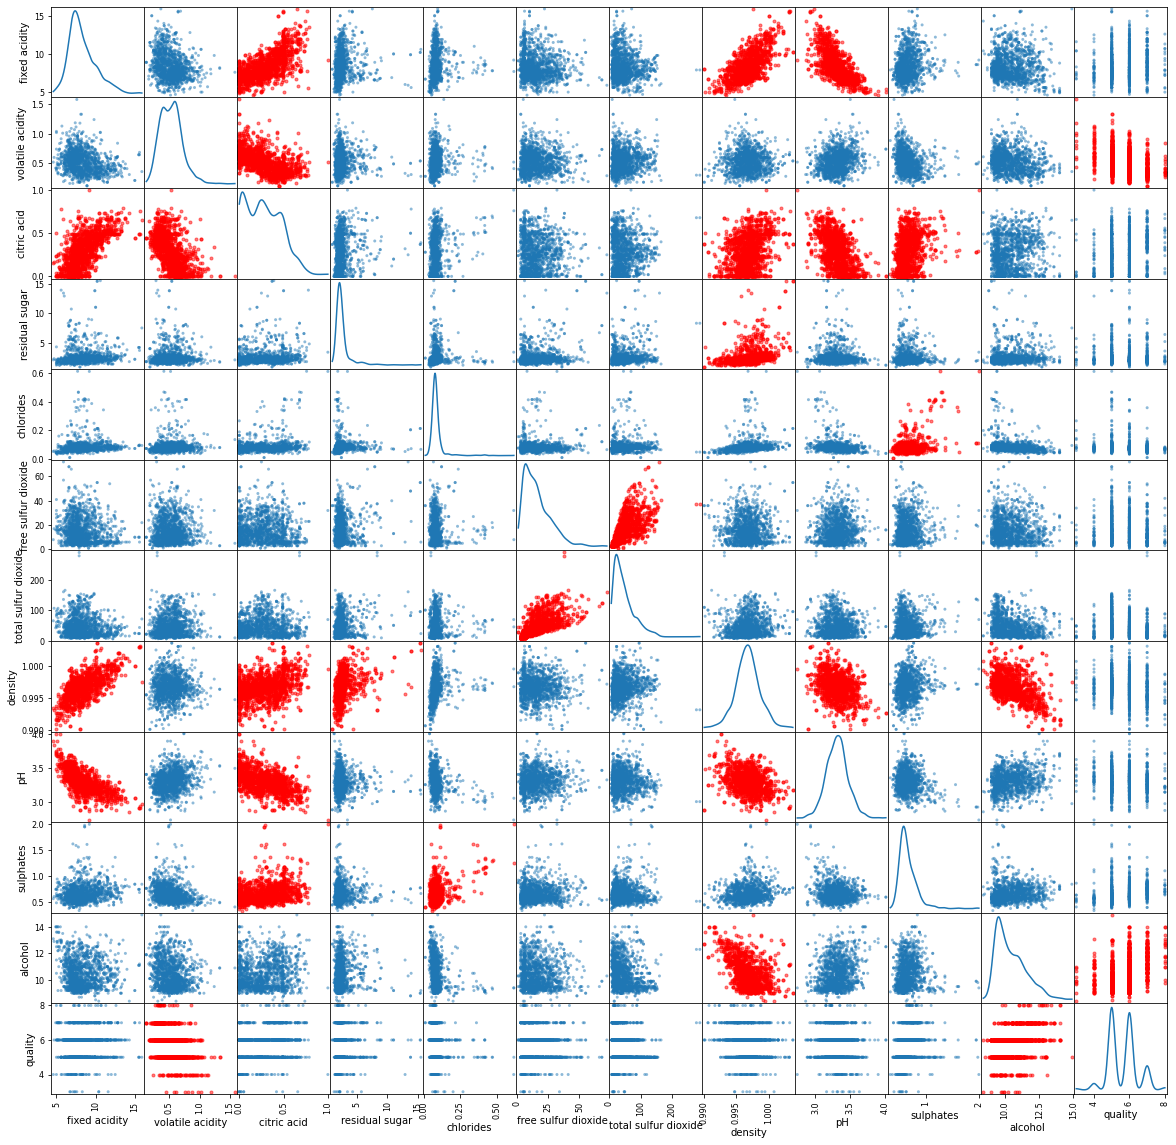

In [24]:
scatter_matrix = pd.plotting.scatter_matrix(df,diagonal="kde",figsize=(20,20));

i = 0
j = 0
n = 12

for ax in scatter_matrix.ravel():
  if i != j:
    c, _ = pearsonr(df.iloc[:,i],df.iloc[:,j])
  else:
    c = 0
  if abs(c) > 0.3:
    ax.get_children()[0].set_color("red")
  i += 1
  if i == n:
    i = 0
    j += 1

We see that higher quality is associated with higher alcohol content and lower volatile acidity.

## Normality and logarithmisation

In [26]:
from scipy.stats import normaltest

In [27]:
import statsmodels.api as sm
import pylab as py

In [28]:
import pylab as py
import scipy.stats as stats

The following graphs are useful for feature engineering. In particular they helped pick the features which fit better on a log-scale.
<br>
With <font color='blue'> blue </font> I will plot the original distribution, together with its qq-plot, comparing it to the normal distribution.
<br>
With <font color='red'> red </font> I will plot the logarthmized distribution, together with its qq-plot.

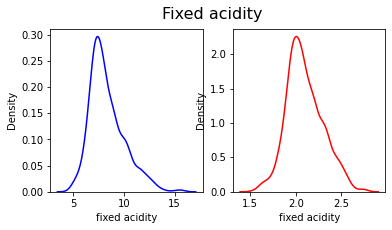

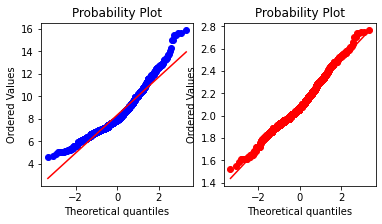

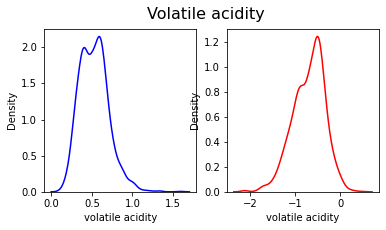

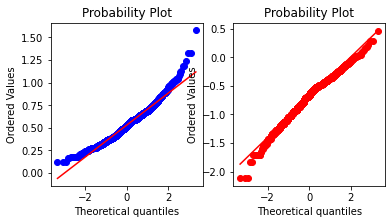

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


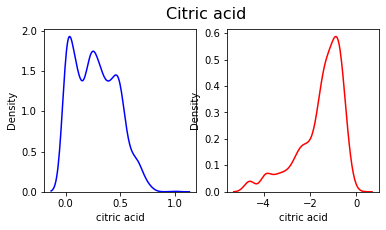

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


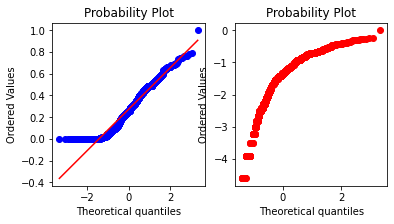

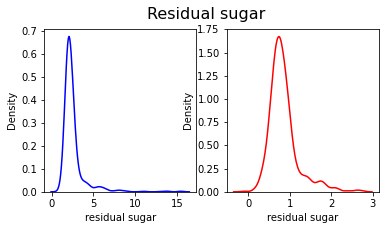

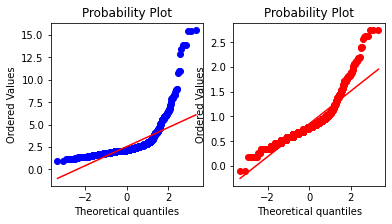

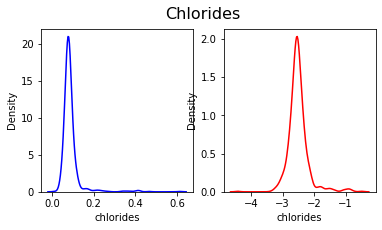

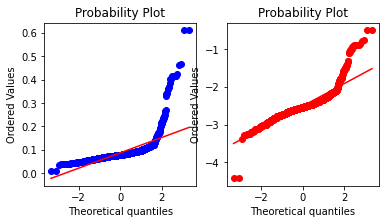

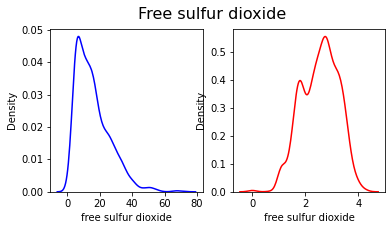

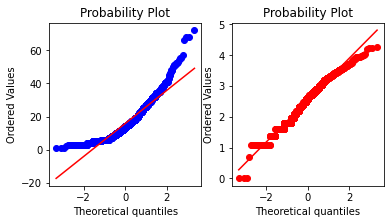

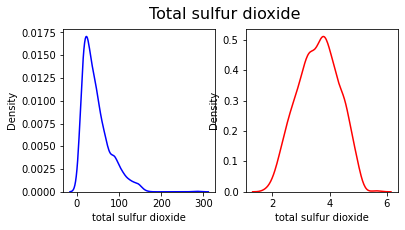

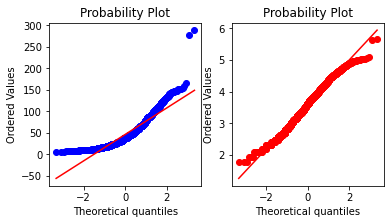

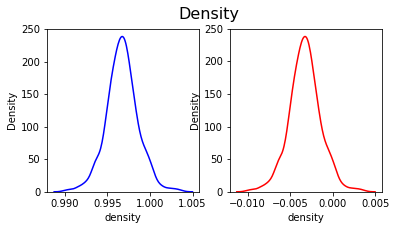

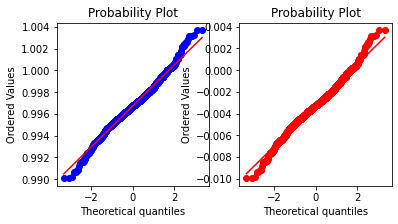

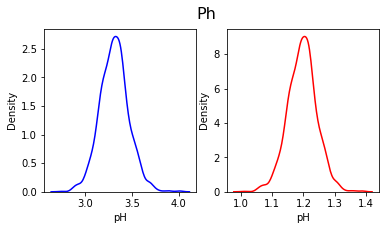

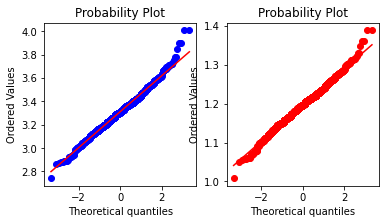

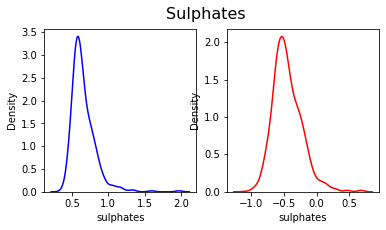

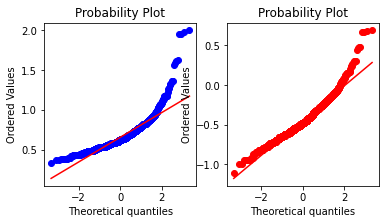

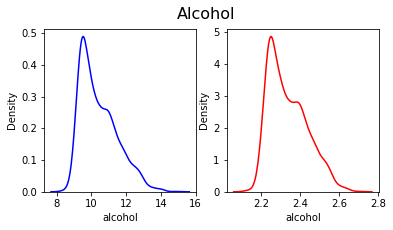

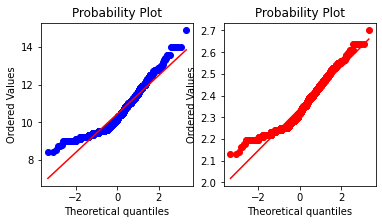

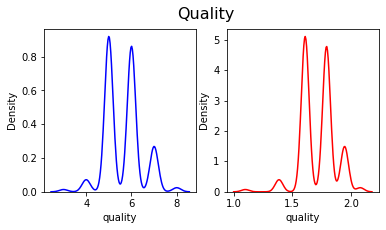

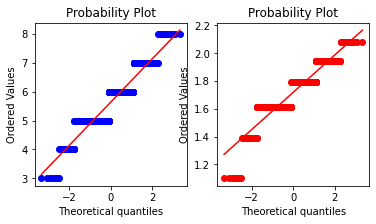

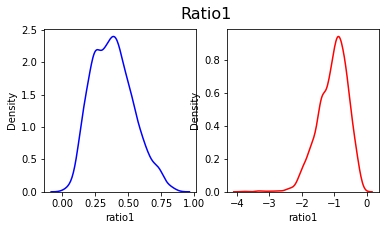

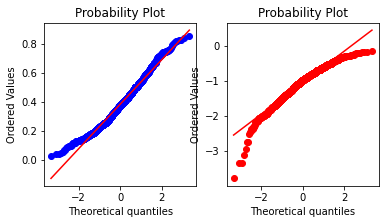

In [29]:
for x in df.columns:
  fig = plt.figure(figsize=(6, 3))
  fig.suptitle(x.capitalize(), fontsize=16)

  plt.subplot(1, 2, 1)
  sns.kdeplot(df[x], color="blue")
  plt.subplot(1, 2, 2)
  sns.kdeplot(np.log(df[x]), color="red")
  plt.show()

  fig = plt.figure(figsize=(6, 3))

  plt.subplot(1, 2, 1)
  stats.probplot(df[x], dist="norm", plot=py)
  ax = plt.subplot(1, 2, 2)
  stats.probplot(np.log(df[x]), dist="norm", plot=py)
  ax.get_lines()[0].set_color('r')
  py.show()

Some features get closer to normality, others don't or they reverse their skew.

Taking into account the nature of the feature and whether there were improvements in normality, I picked the following features to logarithmize:
<br>


*   residual sugar
*   chlorides
*   free sulfur dioxide
*   total sulfur dioxide
*   sulphates

In [30]:
to_log = [
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "sulphates"
]

In [136]:
df_logs = df.copy(deep=True)

for x in to_log:
  df_logs[x] = np.log(df_logs[x])

## Predict alcohol

### Linear regression

In order to predict the alcohol content of a wine, I used 4 linear regressions, with test and training split, using all the features, but with a varying degree of feature engineering, as follows:
<br>
*  No feature engineering
*  Adding the ratio of free vs total sulphur dioxide
*  Some features are logarithmized (as described above)
*  Logarithmized features and ratio

In [137]:
from sklearn.linear_model import LinearRegression

In [138]:
from sklearn import preprocessing

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
from sklearn.metrics import mean_squared_error

In [141]:
def all_except(X, feature):
  return X.loc[:, X.columns != feature]

In [142]:
def lin_reg(X, Y):
  scaler = preprocessing.StandardScaler().fit(X)
  X_scaled = scaler.transform(X)

  X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=0)
  
  reg = LinearRegression().fit(X_train, y_train)

  ser_coefs = pd.Series(reg.coef_.T, index=X.columns)
  print(ser_coefs)

  mse = mean_squared_error(y_test, reg.predict(X_test))

  print("MSE:", mse)

  return mse

In [143]:
lin_reg_models = pd.Series(index=["No FE", "Ratio", "Logs", "Logs Ratio"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [144]:
X = all_except(df, "alcohol")
Y = df["alcohol"]

In [145]:
lin_reg_models["No FE"] = lin_reg(X, Y)

fixed acidity           0.853696
volatile acidity        0.108814
citric acid             0.138880
residual sugar          0.350144
chlorides              -0.036597
free sulfur dioxide    -0.051168
total sulfur dioxide   -0.034692
density                -1.079326
pH                      0.560236
sulphates               0.184730
quality                 0.176680
dtype: float64
MSE: 0.3478889862711499


In [146]:
X["ratio"] = df["free sulfur dioxide"] / df["total sulfur dioxide"]

In [147]:
lin_reg_models["Ratio"] = lin_reg(X, Y)

fixed acidity           0.852569
volatile acidity        0.107944
citric acid             0.138722
residual sugar          0.349650
chlorides              -0.035782
free sulfur dioxide    -0.075220
total sulfur dioxide   -0.010509
density                -1.074177
pH                      0.560225
sulphates               0.183994
quality                 0.176412
ratio                   0.024897
dtype: float64
MSE: 0.3484499313862536


In [148]:
X = all_except(df_logs, "alcohol")
Y = df_logs["alcohol"]

In [149]:
lin_reg_models["Logs"] = lin_reg(X, Y)

fixed acidity           0.881100
volatile acidity        0.082371
citric acid             0.092704
residual sugar          0.456374
chlorides               0.000300
free sulfur dioxide    -0.030779
total sulfur dioxide   -0.062903
density                -1.157961
pH                      0.554888
sulphates               0.204253
quality                 0.137507
dtype: float64
MSE: 0.3176549834408764


In [150]:
X["ratio"] = df["free sulfur dioxide"] / df["total sulfur dioxide"]

In [151]:
lin_reg_models["Logs Ratio"] = lin_reg(X, Y)

fixed acidity           0.881264
volatile acidity        0.082341
citric acid             0.092312
residual sugar          0.456305
chlorides               0.000450
free sulfur dioxide    -0.020496
total sulfur dioxide   -0.073126
density                -1.158320
pH                      0.554909
sulphates               0.204442
quality                 0.137607
ratio                  -0.007002
dtype: float64
MSE: 0.3177758411445053


In [152]:
print("Models MSEs:")
lin_reg_models

Models MSEs:


No FE         0.347889
Ratio         0.348450
Logs          0.317655
Logs Ratio    0.317776
dtype: float64

The best performing model (with lowest MSE) is the third, with logarithmized features, but excluding the ratio between free and total sulphur dioxide.

#### Check multicolinearity

In [153]:
X = all_except(df_logs, "alcohol")
Y = df_logs["alcohol"]

An acceptable VIF (Variance inflation factor) is one which is smaller than 10.

In [154]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [155]:
def check_vif(X):
  vif_data = pd.DataFrame()
  vif_data["feature"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  return vif_data

I will compute VIF for all predictive features.

In [156]:
check_vif(X)

,feature,VIF
0,fixed acidity,67.971047
1,volatile acidity,17.658778
2,citric acid,8.287112
3,residual sugar,7.322209
4,chlorides,78.789337
5,free sulfur dioxide,41.697325
6,total sulfur dioxide,80.634809
7,density,1436.733286
8,pH,990.502931
9,sulphates,6.697627


#### Check heteroskedasticity

In [291]:
def check_heteroskedasticity(X, Y, reg):
  predictions = reg.predict(X)
  errors = predictions - Y

  for feature in X.columns:
    sns.scatterplot(X[feature], errors, s = 5)
    plt.show()

The following graphs compare the error with each feature, in order to see if there is heteroskedasticity.

In [290]:
X = all_except(df_logs, "alcohol")
Y = df_logs["alcohol"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

reg = LinearRegression().fit(X, Y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


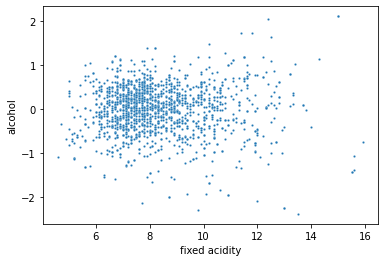

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


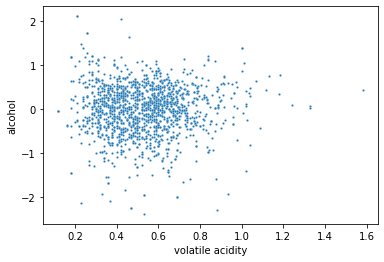

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


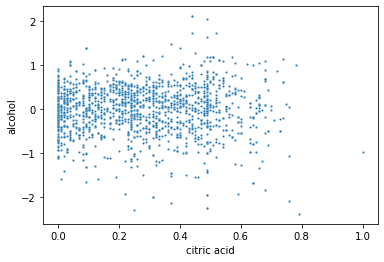

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


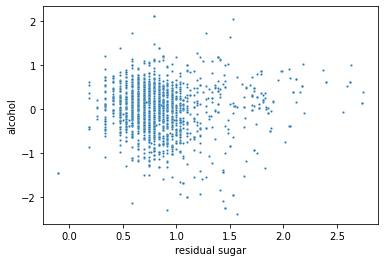

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


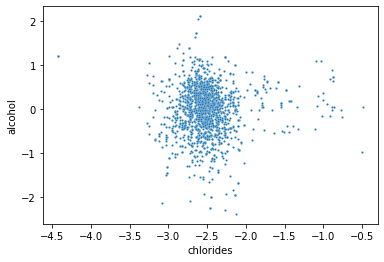

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


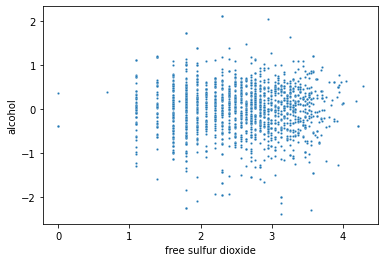

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


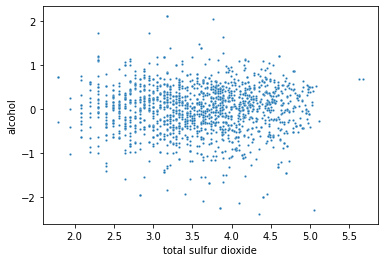

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


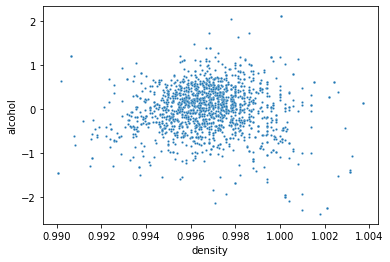

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


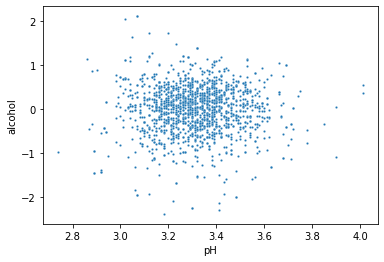

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


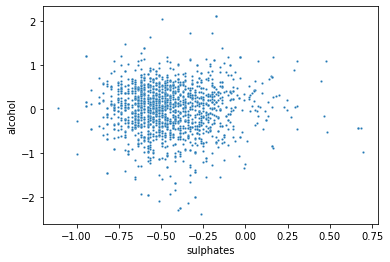

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


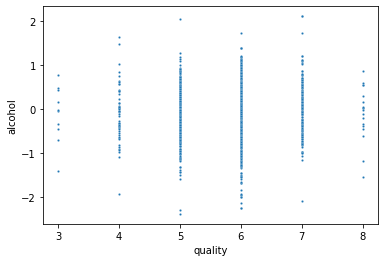

In [294]:
check_heteroskedasticity(X, Y, reg)

All graphs look fine!

## Predict quality

Next I will predict quality. In addition to the information criterias, I will use the predicted profit made from testing and selling the high quality wine.
<br>
Let's say that, based on previous observations, we get, on average, 400 euros from selling one type of wine. Also, testing a wine costs 100 euros.
<br>
Given that, we will select for testing only the wines which are predicted to be profitable (the probability of them being of high quality is greater than 25%).

### Ordinal regression

I will create an ordinal regression for predicting the "quality" feature, using the logit model. All the grades are between 3 and 8. Each grade represents a level within the regression.

In [159]:
!pip uninstall statsmodels

Found existing installation: statsmodels 0.13.2
Uninstalling statsmodels-0.13.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.13.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 86, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 658, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 380, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 423, in _allow

In [160]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [162]:
from pandas.api.types import CategoricalDtype
quality_as_type = CategoricalDtype(categories=[i for i in range(3,9)], ordered=True)

In [260]:
X = all_except(df_logs, "quality")
Y = df["quality"]

In [261]:
Y = Y.astype(quality_as_type)

In [262]:
random_state = 0

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
  X_scaled, Y, test_size=0.5, random_state=random_state)

In [263]:
mod_log = OrderedModel(y_train, X_train, distr="logit")

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                quality   Log-Likelihood:                -759.59
Model:                   OrderedModel   AIC:                             1551.
Method:            Maximum Likelihood   BIC:                             1626.
Date:                Wed, 14 Sep 2022                                         
Time:                        13:11:46                                         
No. Observations:                 799                                         
Df Residuals:                     783                                         
Df Model:                          16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3552      0.208      1.709      0.087      -0.052       0.762
x2            -0.6211      0.097     -6.402      0.000      -0.811      -0.431
x3            -0.1418      0.121     -1.175      0.240      -0.378       0.095
x4             0.2802      0.103      2.715      0.007       0.078       0.483
x5            -0.2808      0.080     -3.509      0.000      -0.438      -0.124
x6             0.0685      0.121      0.567      0.571      -0.169       0.306
x7            -0.3166      0.128     -2.480      0.013      -0.567      -0.066
x8            -0.3728      0.202     -1.847      0.065      -0.768       0.023
x9            -0.0914      0.130     -0.701      0.483      -0.347       0.164
x10            0.6362      0.086      7.418      0.000       0.468       0.804
x11            0.7185      0.136      5.270      0.000       0.451       0.986
3/4           -6.1065      0.461    -13.244      0.000      -7.010      -5.203
4/5            0.6658      0.215      3.097      0.002       0.244       1.087
5/6            1.3272      0.055     24.016      0.000       1.219       1.436
6/7            1.0356      0.055     18.901      0.000       0.928       1.143
7/8            1.2116      0.103     11.739      0.000       1.009       1.414
==============================================================================
"""

In [264]:
worth_it = (1 - res_log.predict(X_test, which="cumprob")[:,-3]) > 0.25

In [265]:
profit = (worth_it & ((y_test==7) | (y_test==8))).sum() * 400 - worth_it.sum() * 100
print("Profit:", profit, "euro")

Profit: 8900 euro


In [267]:
wt = worth_it.sum()
print("Number of wines tested:", wt)

Number of wines tested: 175


## Detect high quality

Next, I will do 4 simple logistic regressions, with the same kind of feature engineering as in predicting alcohol.

In [170]:
from sklearn.linear_model import LogisticRegression

In [171]:
from sklearn.model_selection import train_test_split

In [172]:
from sklearn.metrics import average_precision_score

In [233]:
def log_reg(X, Y, random_state=0):
  scaler = preprocessing.StandardScaler().fit(X)
  X_scaled = scaler.transform(X)

  X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=random_state)
  
  model = LogisticRegression(solver='lbfgs')

  reg = model.fit(X_train, y_train)

  worth_it = (reg.predict_proba(X_test)[:, 1] > 0.25)

  wines_to_test_count = worth_it.sum()

  profit = (worth_it & y_test).sum() * 400 - worth_it.sum() * 100

  PR_AUC = average_precision_score(y_test, reg.predict_proba(X_test)[:, 1])

  return wines_to_test_count, profit, PR_AUC

In [270]:
def print_results(X, Y, text=""):
  print(text)
  res = log_reg(X, Y)
  print("Number of wines tested:", res[0])
  print("Profit", res[1], "euro")
  print("PR AUC:", res[2])

In [271]:
X = all_except(df, "quality")
Y = (df["quality"] >= 7)

In [272]:
print_results(X, Y, "No FE")

No FE
Number of wines tested: 174
Profit 7400 euro
PR AUC: 0.4510637354289422


In [273]:
X = all_except(df, "quality")
Y = (df["quality"] >= 7)
X["ratio"] = df["free sulfur dioxide"] / df["total sulfur dioxide"]

In [274]:
print_results(X, Y, "Ratio")

Ratio
Number of wines tested: 169
Profit 7100 euro
PR AUC: 0.4690818464069301


In [275]:
X = all_except(df_logs, "quality")
Y = (df["quality"] >= 7)

In [276]:
print_results(X, Y, "Logs")

Logs
Number of wines tested: 167
Profit 8900 euro
PR AUC: 0.4701558914563453


In [277]:
X = all_except(df_logs, "quality")
Y = (df["quality"] >= 7)
X["ratio"] = df["free sulfur dioxide"] / df["total sulfur dioxide"]

In [278]:
print_results(X, Y, "Logs and Ratio")

Logs and Ratio
Number of wines tested: 161
Profit 8700 euro
PR AUC: 0.47630185370310785


In [279]:
from statistics import mean

In [280]:
def test_splits(X, Y):
  profits = []
  PR_AUCs = []

  for i in range(100):
    _, profit, PR_AUC = log_reg(X, Y, i)
    profits.append(profit)
    PR_AUCs.append(PR_AUC)

  print(mean(profits))
  print(mean(PR_AUCs))

In [285]:
X = all_except(df_logs, "quality")
Y = (df["quality"] >= 7)

In [286]:
print("Logs")
test_splits(X, Y)

Logs
13797
0.525142852618455


In [288]:
X = all_except(df_logs, "quality")
Y = (df["quality"] >= 7)
X["ratio"] = df["free sulfur dioxide"] / df["total sulfur dioxide"]

In [289]:
print("Logs and Ratio")
test_splits(X, Y)

Logs and Ratio
13756
0.5240657226198674
